In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import random

In [34]:
# 1. TẠO MẠNG LƯỚI THÀNH PHỐ (GRID GRAPH)
# ==========================================
# Tạo lưới 15x15 (giống đường phố bàn cờ Manhattan)
width, height = 30, 30
G = nx.grid_2d_graph(width, height)

# Gán trọng số cho tất cả các cạnh là 1 (đơn vị khoảng cách)
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = 1.0

# Lấy vị trí để vẽ (Node của grid_2d_graph chính là toạ độ x,y)
pos = {node: node for node in G.nodes()}
print("Thành công !")

Thành công !


In [35]:
# ==========================================
# 2. SINH DỮ LIỆU MẪU (150 ĐIỂM)
# ==========================================
# Chúng ta sẽ tạo dữ liệu tập trung quanh 3 "Hotspot" và một ít Nhiễu
data_nodes = []

# Hàm hỗ trợ lấy các node xung quanh một tâm (để tạo cụm giả lập)
def get_nearby_nodes(center_node, radius, count):
    candidates = []
    for node in G.nodes():
        # Tính khoảng cách Manhattan đơn giản để lọc nhanh
        dist = abs(node[0] - center_node[0]) + abs(node[1] - center_node[1])
        if dist <= radius:
            candidates.append(node)
    return random.sample(candidates, min(len(candidates), count))
    #return random.choices(candidates, k=count)

# -> Tạo Cụm 1 (Góc dưới trái): Tập trung đông đúc
data_nodes.extend(get_nearby_nodes((5, 5), radius=4, count=50))

# -> Tạo Cụm 2 (Góc trên phải): Tập trung vừa phải
data_nodes.extend(get_nearby_nodes((20, 20), radius=4, count=40))

# -> Tạo Cụm 3 (Ở giữa): Nhỏ hơn
data_nodes.extend(get_nearby_nodes((15, 15), radius=3, count=30))

# -> Tạo Nhiễu (Noise): 40 điểm rải rác ngẫu nhiên toàn bản đồ
all_nodes = list(G.nodes())
noise_points = random.sample(all_nodes, 40)
data_nodes.extend(noise_points)

# Xóa trùng lặp (nếu có)
data_nodes = list(set(data_nodes))
n_samples = len(data_nodes)

print(f"Tổng số điểm dữ liệu: {n_samples}")

Tổng số điểm dữ liệu: 144


In [36]:
# ==========================================
# 3. TÍNH MA TRẬN KHOẢNG CÁCH MẠNG (DIJKSTRA)
# ==========================================
# Bước này tốn thời gian nhất (độ phức tạp O(N^2 * Graph_Size))
# Với 150 điểm thì vẫn chạy rất nhanh (< 1 giây)
dist_matrix = np.zeros((n_samples, n_samples))

print("Đang tính toán khoảng cách mạng lưới...")
for i in range(n_samples):
    for j in range(i + 1, n_samples):
        u = data_nodes[i]
        v = data_nodes[j]
        # Tính đường đi ngắn nhất thực tế trên lưới
        d = nx.shortest_path_length(G, source=u, target=v, weight='weight')
        dist_matrix[i, j] = d
        dist_matrix[j, i] = d

Đang tính toán khoảng cách mạng lưới...


In [37]:
# ==========================================
# 4. CHẠY NS-DBSCAN
# ==========================================
# Eps = 2.5 (Khoảng cách mạng): Tức là đi bộ khoảng 2.5 block nhà
# MinPts = 4: Cần ít nhất 4 điểm để thành cụm
db = DBSCAN(eps=1.5, min_samples=4, metric='precomputed')
labels = db.fit_predict(dist_matrix)

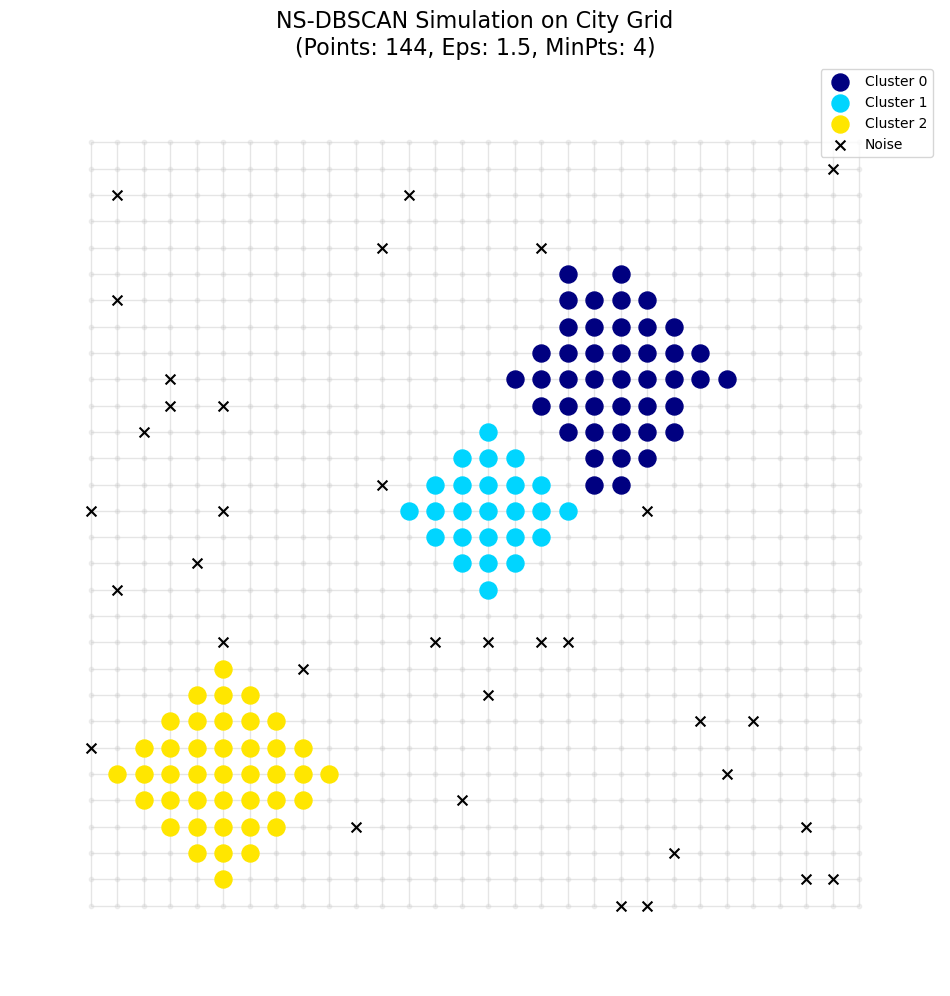

In [38]:
# ==========================================
# 5. VẼ KẾT QUẢ (ĐÃ SỬA LỖI)
# ==========================================
plt.figure(figsize=(12, 12))

# Vẽ nền đường phố (Mờ nhạt)
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='lightgray', alpha=0.3)

# Chuẩn bị màu sắc
unique_labels = set(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

# Vẽ từng cụm
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Điểm Nhiễu (Noise) -> Vẽ màu Đen, nhỏ hơn, hình dấu X
        mask = (labels == k)
        nodes_in_cluster = [data_nodes[i] for i in range(len(labels)) if mask[i]]
        
        # --- SỬA LỖI TẠI ĐÂY: marker -> node_shape ---
        nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_cluster, 
                               node_color='black', node_size=50, node_shape='x', label='Noise')
    else:
        # Các Cụm -> Vẽ màu sắc rực rỡ, hình tròn (mặc định là 'o')
        mask = (labels == k)
        nodes_in_cluster = [data_nodes[i] for i in range(len(labels)) if mask[i]]
        
        # Lưu ý: node_color cần là một list hoặc array nếu truyền vào 1 màu duy nhất bọc trong list
        nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_cluster, 
                               node_color=[col], node_size=150, node_shape='o', label=f'Cluster {k}')

plt.title(f"NS-DBSCAN Simulation on City Grid\n(Points: {n_samples}, Eps: 1.5, MinPts: 4)", fontsize=16)
plt.legend()
plt.axis('off')
plt.show()